Tom Barclay's xoflares on EPIC-246301900

In [1]:
import sys
sys.version

'3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 20:58:55) \n[Clang 11.0.0 ]'

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import search
import theano
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess
import theano.tensor as tt
from scipy.signal import savgol_filter
from pymc3.step_methods.hmc import quadpotential
import corner
import pandas as pd

In [3]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)
print(lk.__version__)

0.4.4
1.0.4
3.9.3
2.0.3


In [3]:
"""
lc = search.search_targetpixelfile('EPIC 246301900').download()
lc.to_lightcurve().plot()
ref_time = 0.5 * (lc.time.min() + lc.time.max())
"""

"\nlc = search.search_targetpixelfile('EPIC 246301900').download()\nlc.to_lightcurve().plot()\nref_time = 0.5 * (lc.time.min() + lc.time.max())\n"

In [4]:
"""lc = lc.to_lightcurve()
print(lc.flux.shape)
"""

'lc = lc.to_lightcurve()\nprint(lc.flux.shape)\n'

In [4]:
from astropy.io import fits
filename = '/Users/chris/Desktop/superflares/ktwo246301900-c12_llc.fits'
hdul = fits.open(filename)
hdul.info()

Filename: /Users/chris/Desktop/superflares/ktwo246301900-c12_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   3862R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (10, 8)   int32   


In [5]:
data = fits.getdata(filename,header=True,ext=1)
lc = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder()) # to avoid big-endian/little-endian mixup: https://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
print(lc.head())

          TIME  TIMECORR  CADENCENO     SAP_FLUX  SAP_FLUX_ERR       SAP_BKG  \
0  2905.377230  0.005332     136855  614164.8125     22.716827  19529.195312   
1  2905.397662  0.005331     136856  614196.0000     22.708811  19530.005859   
2  2905.418095  0.005329     136857  614179.6250     22.713530  19541.736328   
3  2905.438527  0.005328     136858  614099.5000     22.717106  19533.994141   
4  2905.458959  0.005327     136859  614238.1875     22.723835  19532.445312   

   SAP_BKG_ERR  PDCSAP_FLUX  PDCSAP_FLUX_ERR  SAP_QUALITY  PSF_CENTR1  \
0     7.201994          NaN              NaN       524288         NaN   
1     7.175916  612915.2500        22.353420            0         NaN   
2     7.180060  612892.8125        22.366695            0         NaN   
3     7.191803  612824.8125        22.378389            0         NaN   
4     7.191343  612975.3750        22.391329            0         NaN   

   PSF_CENTR1_ERR  PSF_CENTR2  PSF_CENTR2_ERR  MOM_CENTR1  MOM_CENTR1_ERR  \
0  

In [6]:
### PREP

# divide data into pre-flare, post-flare/pre-gap, and post-flare/post-gap
lc = lc.dropna(subset=['TIME','PDCSAP_FLUX','PDCSAP_FLUX_ERR']) # toss NaNs since they'll create matrices of NaNs
print(len(lc))

pre = lc.loc[:1611] # next record is the beginning of the flare, so stop here
post = lc.loc[1614:2336] # start from after the flare until beginning of the gap in time series data
postgap = lc.loc[2337:] # start from end of the gap in data until end of time series data

# calculate reference (average) time
def calculate_ref_time(lc):
    return 0.5 * (np.min(lc.TIME) + np.max(lc.TIME))

# calculate normalized flux
def normalize_flux(lc):
    return (lc/np.median(lc)) - 1

3255


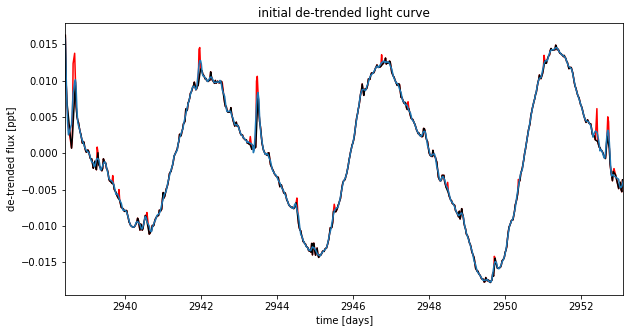

In [7]:
# get a smoothed version of the light curve
norm_y = normalize_flux(post.PDCSAP_FLUX)
smooth = savgol_filter(norm_y, 9, polyorder=3)
resid = norm_y - smooth
mask = resid < 1.5*np.sqrt(np.mean(resid**2))

plt.figure(figsize=(10, 5))
plt.plot(post.TIME, norm_y, "r")
plt.plot(post.TIME[mask], norm_y[mask], "k")
plt.plot(post.TIME, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
#plt.ylim(580000, 680000)
plt.xlim(post.TIME.min(), post.TIME.max());

In [8]:
def find_flares(lc):

    # find some flares
    mflare = resid < 1.5 * np.sqrt(np.mean(resid**2))
    lc.CADENCENO = lc.CADENCENO
    cads = lc.CADENCENO - list(lc.CADENCENO)[0] # index at 0
    ref_time = calculate_ref_time(lc)
    x = lc.TIME - ref_time # subtract time by average time
    y = resid # data with savgol subtracted

    fidx = cads.loc[~mflare][:-1]#[np.diff(cads[~mflare]) < 1]
    fidx = list(fidx) # address indexing errors
    npts = np.array([])
    i = 0
    n = 1
    while True:
        try:
            if fidx[i + 1] == fidx[i] + n:
                # measure flare: keep track of number of points (fatness) of a flare
                fidx = np.delete(fidx, i + 1)
                n += 1
            else:
                # count flare: concatenate to array, advance, and reset count
                npts = np.r_[npts, n+1] 
                i += 1
                n = 1
        except IndexError:
            npts = np.r_[npts, n+1]
            break
    tpeaks = np.array([x.loc[(lc.CADENCENO - list(lc.CADENCENO)[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
    ampls = np.array([resid.loc[(lc.CADENCENO - list(lc.CADENCENO)[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
    fwhms = np.asarray(npts) * (2/1440)
    npeaks = np.shape(tpeaks)[0]
    #print(tpeaks, ampls, fwhms, npeaks)
    return x, y, tpeaks, ampls, fwhms, npeaks

x, y, tpeaks, ampls, fwhms, npeaks = find_flares(post)

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [9]:
tpeaks

array([-7.27363327, -7.13061199, -7.08974877, -6.49723207, -6.08859993,
       -5.92514715, -5.18960967, -3.82069349, -3.20774608, -2.47220963,
       -2.39048328, -2.30875702, -1.24631585, -0.26560119,  0.98072315,
        1.67539552,  2.71740387,  3.94329566,  4.57667296,  5.25091312,
        6.64025654,  6.92629784])

In [ ]:
"""# get a smoothed version of the light curve
smooth = savgol_filter(lc.flux, 13, polyorder=3)
resid = lc.flux - smooth
mask = resid < 2*np.sqrt(np.mean(resid**2))

plt.figure(figsize=(10, 5))
plt.plot(lc.time, lc.flux, "r")
plt.plot(lc.time[mask], lc.flux[mask], "k")
plt.plot(lc.time, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.ylim(580000, 680000)
plt.xlim(lc.time.min(), lc.time.max());
"""

**Check if times of predicted flares match up**

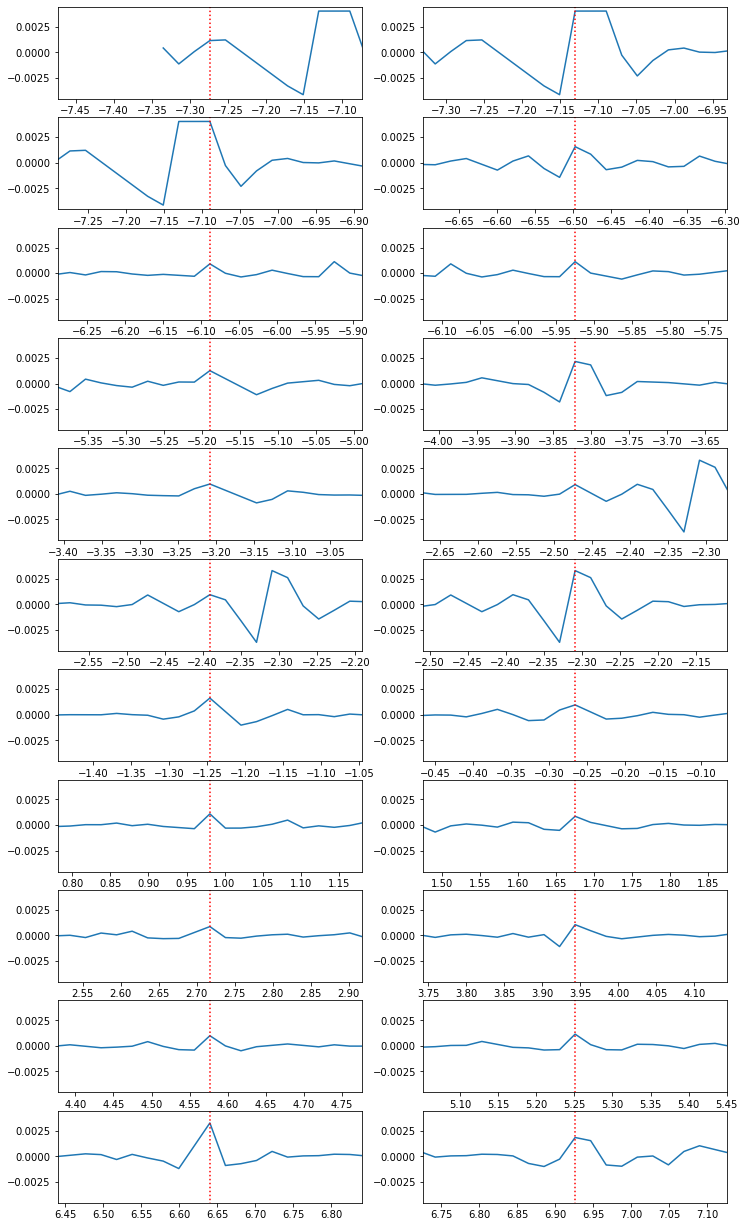

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, y)
    #ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.axvline(tpeaks[i], -1, 1, color='r', linestyle=':')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    #ax.set_ylim(np.min(y), np.max(ampls[i]+3))

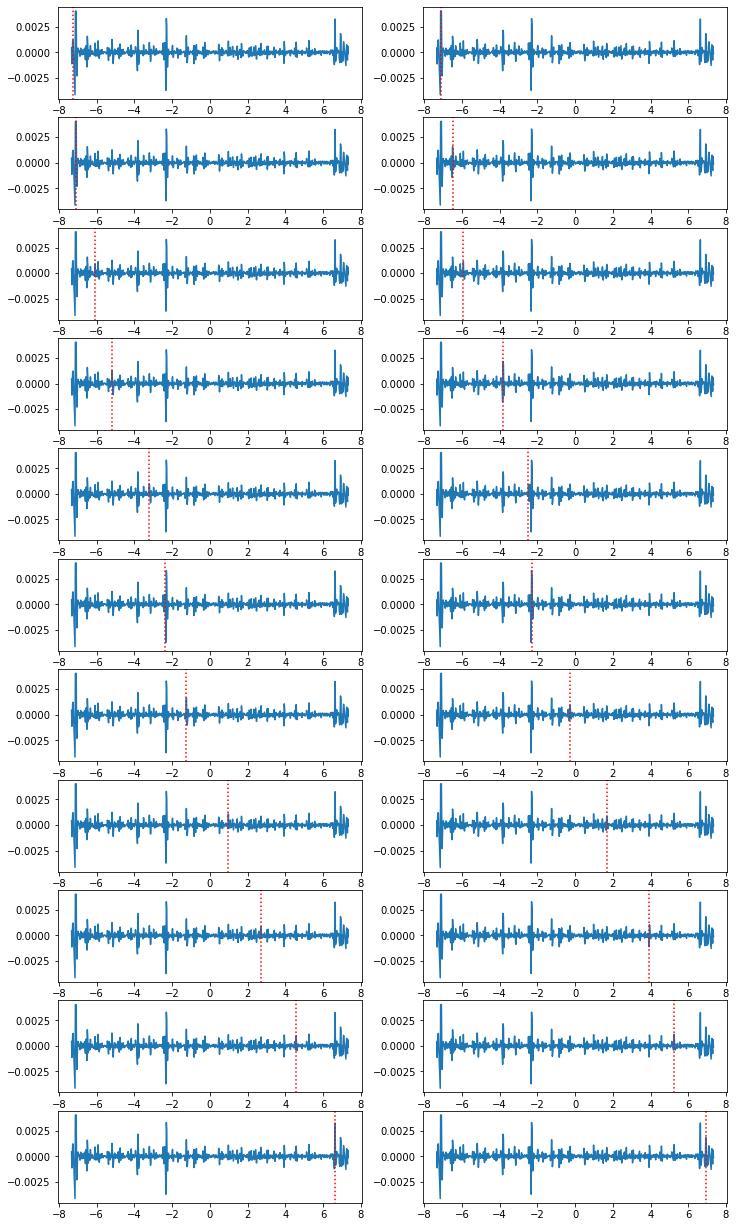

In [12]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, y)
    #ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.axvline(tpeaks[i], -1, 1, color='r', linestyle=':')


In [10]:
# this is the flare model implemented in theano
def get_light_curve(time, tpeaks, fwhms, ampls, texp=None, oversample=7):
    time = time.astype('float64')
    time = tt.as_tensor_variable(time)
    
    if texp is None:
        tgrid = time
    if texp is not None:
        # taking this oversample code from
        # https://github.com/dfm/exoplanet
        # and https://github.com/lkreidberg/batman
        oversample = int(oversample)
        oversample += 1 - oversample % 2
        dt = np.linspace(-texp / 2., texp / 2.,
                         oversample)
        tgrid = tt.shape_padright(time) + dt
        
    multiflare_lc = multiflaremodel(tgrid, tpeaks, fwhms, ampls)
    
    if texp is not None:
        multiflare_lc = tt.mean(tt.reshape(multiflare_lc, (-1, oversample)),
            axis=1)

    return multiflare_lc

def multiflaremodel(t, tpeaks, fwhms, ampls):
    t = t.astype('float64')
    t = tt.as_tensor_variable(t)
    multiflare_lc = tt.zeros_like(t)
    flare_lc = tt.zeros_like(t)
    
    def scan_func(tpeak, fwhm, ampl):
        zeropad_flare_lc = tt.zeros_like(t)
        tcut = (((t - tpeak)/fwhm > -1.) * ((t - tpeak)/fwhm < 20.)).nonzero()
        flare_lc = _flaremodel(t[tcut], tpeak, fwhm, ampl)
        zeropad_flare_lc = tt.set_subtensor(zeropad_flare_lc[tcut],  flare_lc)
        return zeropad_flare_lc
    
    components, updates = theano.scan(fn=scan_func,
                                      sequences=[tpeaks, fwhms, ampls],
                                      )
    multiflare_lc = tt.sum(components, axis=0)
    
#     for i in range(npeaks):
#         tcut = (((t - tpeaks[i])/fwhms[i] > -1.) * ((t - tpeaks[i])/fwhms[i] < 20.)).nonzero()
#         flare_lc = _flaremodel(t[tcut], tpeaks[i], fwhms[i], ampls[i])
#         multiflare_lc = tt.set_subtensor(multiflare_lc[tcut],  multiflare_lc[tcut] + flare_lc)
    return multiflare_lc

def _flaremodel(t, tpeak, fwhm, ampl):
    # reuses some code from AltaiPony and Apaloosa
    t = tt.as_tensor_variable(t)
    flare_lc = tt.zeros_like(t)
    flare_lc = tt.where((t <= tpeak) * ((t - tpeak)/fwhm > -1.),
                        before_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    flare_lc = tt.where((t > tpeak) * ((t - tpeak)/fwhm < 20.),
                        after_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    return flare_lc

def before_flare(t, tpeak, fwhm, ampl):
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    fout = ((_fr[0] + _fr[1] * ((t - tpeak) / fwhm) +
                        _fr[2] * ((t - tpeak) / fwhm)**2. +
                        _fr[3] * ((t - tpeak) / fwhm)**3. +
                        _fr[4] * ((t - tpeak) / fwhm)**4. ) *
                        ampl)
    return fout

def after_flare(t, tpeak, fwhm, ampl):
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]
    fout = ((_fd[0] * tt.exp( ((t - tpeak) / fwhm) * _fd[1]) +
             _fd[2] * tt.exp( ((t - tpeak) / fwhm) * _fd[3] )) *
            ampl)
    return fout

xx = tt.dvector('xx')
tpeaksx = tt.dvector('tpeaksx')
fwhmsx = tt.dvector('fwhmsx')
amplsx = tt.dvector('amplsx')
#texp = 0.001388888888888889
#multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
#                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx, texp=texp))
theano.config.compute_test_value = 'ignore'
multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx))



In [11]:
# with pm.Model() as model:
#     mean = pm.Normal("mean", mu=0, sd=3.0)
#     logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=5.0)
    
#     tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.05,
#                       testval=tpeaks, shape=npeaks)
#     logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=3.0, testval=np.log(0.001), shape=npeaks)
#     logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=3.0, testval=np.log(10*np.var(y)), shape=npeaks)
    
#     fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
#     ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
#     flare_lc = multiflaremodel(x, tpeak, fwhm, ampl, npeaks=npeaks)
#     pm.Deterministic("flare_lc", flare_lc)
#     pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)
    
#     map_soln = pm.find_MAP(start=model.test_point, vars=[fwhm, mean])
#     map_soln = pm.find_MAP(start=map_soln, vars=[ampl, mean])
#     map_soln = pm.find_MAP(start=map_soln, vars=[fwhm, ampl])
#     map_soln = pm.find_MAP(start=map_soln, vars=[tpeak])

# make a fine grid that spans the observation window for plotting purposes
t_plot = np.linspace(x.min(), x.max(), 10000)

with pm.Model() as model:
    npeaks = np.shape(tpeaks)[0]
    mean = pm.Normal("mean", mu=0, sd=3.0, testval=0)
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=2.0)
    
    tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.003,
                      testval=tpeaks, shape=npeaks)
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.0, testval=np.log(fwhms),
                        shape=npeaks)
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, testval=np.log(ampls),
                        shape=npeaks)
    
    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
    #flare_lc = get_light_curve(x, tpeak, fwhm, ampl, texp=texp, oversample=15)
    flare_lc = get_light_curve(x, tpeak, fwhm, ampl, oversample=7)
    flare_lc_pred = get_light_curve(t_plot, tpeak, fwhm, ampl, oversample=7) # this one's for plotting only
    pm.Deterministic("flare_lc", flare_lc)
    pm.Deterministic("flare_lc_pred", flare_lc_pred) # this one's for plotting only
    pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)
    
    map_soln = xo.optimize(start=model.test_point, vars=[1/fwhm, mean])
    map_soln = xo.optimize(start=map_soln, vars=[1/ampl, mean])
    map_soln = xo.optimize(start=map_soln, vars=[1/fwhm, 1/ampl])
    map_soln = xo.optimize(start=map_soln, vars=[tpeak])
    
    approx = pm.MeanField(start=map_soln)
    pm.fit(method=pm.KLqp(approx), n=200000,
            obj_optimizer=pm.adagrad_window
        )
    start = approx.sample(draws=2, ) # formerly draws=4
    start = list(start)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model.dict_to_array(stds) ** 2
    potential = quadpotential.QuadPotentialDiag(cov)

optimizing logp for variables: [mean, logFwhm]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -6.384334852169708e+21 -> -6.209889104285413e+21
optimizing logp for variables: [mean, logAmpl]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -6.209889104285413e+21 -> -6.202755980508874e+21
optimizing logp for variables: [logAmpl, logFwhm]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -6.202755980508874e+21 -> -6.146308131830016e+21
optimizing logp for variables: [tpeak]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -6.146308131830016e+21 -> -6.146308131830016e+21


Finished [100%]: Average Loss = -4,081.8


In [12]:
start[0]['tpeak'] - 0.2

array([-7.47707226, -7.33259582, -7.28994971, -6.69764609, -6.28820145,
       -6.12475225, -5.39231376, -4.02210078, -3.408993  , -2.66885767,
       -2.58970135, -2.50848214, -1.44691955, -0.46313928,  0.78456964,
        1.47112908,  2.51312704,  3.74163249,  4.38371889,  5.04782591,
        6.44024185,  6.72589407])

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressio

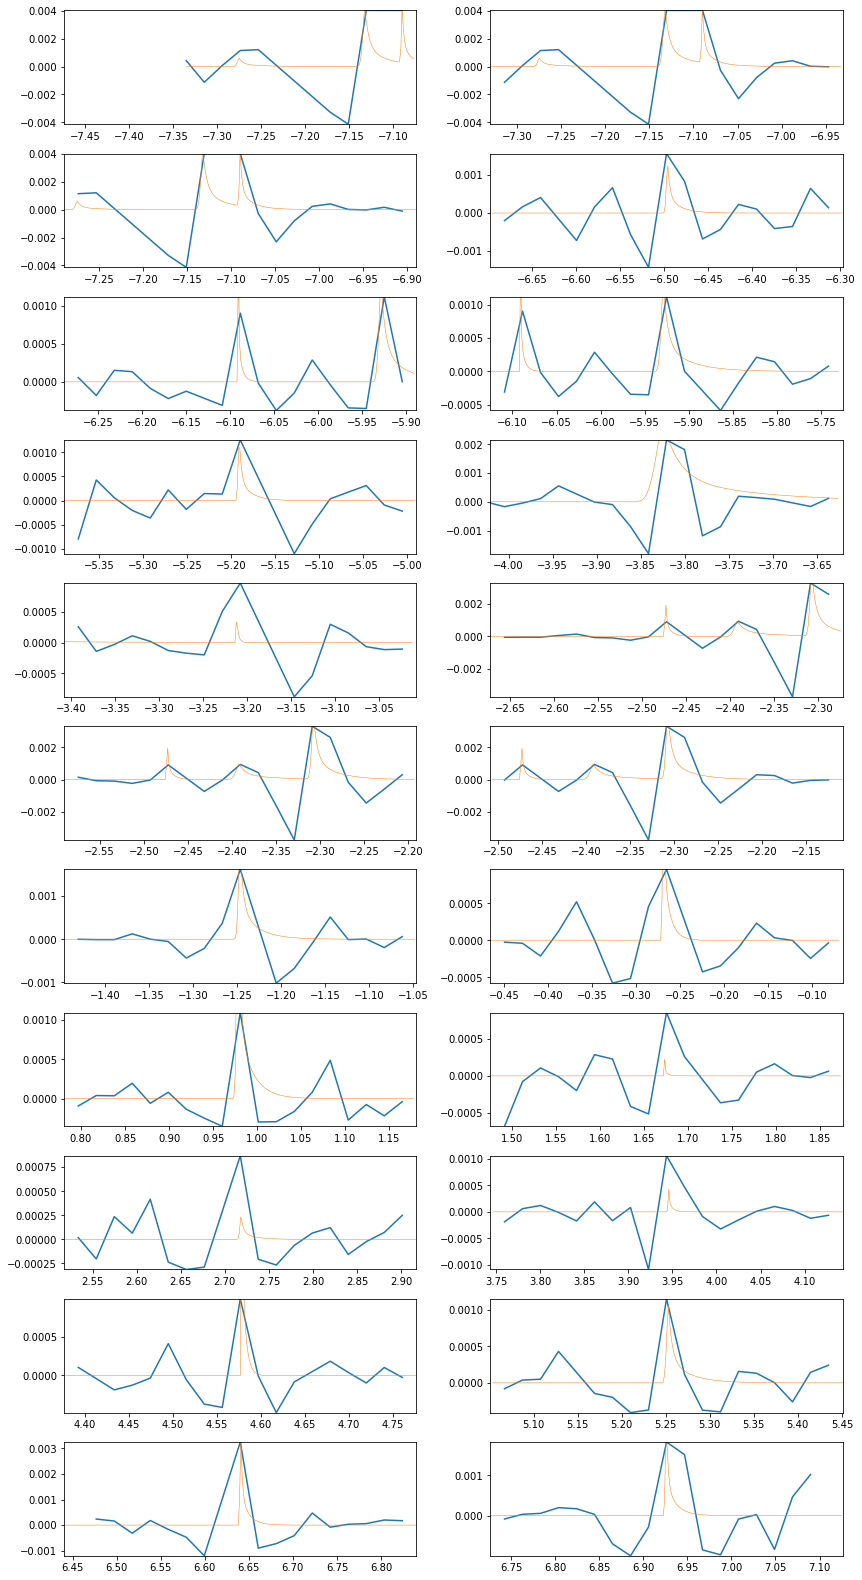

In [20]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
tps = start[0]['tpeak']
for i in range(npeaks):
    timemask = (x >= tps[i]-0.2) * (x < tps[i]+0.2) # true for values within +/- 0.2 of peak indices
    timemask_t_plot = (t_plot >= tps[i]-0.2) * (t_plot < tps[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask])
    #ax.plot(x[timemask], start[0]['flare_lc'][timemask], ':r')
    with model:
        ax.plot(
            t_plot[timemask_t_plot], 
            pmx.eval_in_model(get_light_curve(t_plot, tpeak, fwhm, ampl, oversample=7), start[0])[timemask_t_plot],
            "C1", lw=0.5
        )
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y[timemask]), np.max(y[timemask]))
fig.tight_layout()

#fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
#axes = axes.flatten()
#for i in range(npeaks):
#    ax = axes[i]
#    ax.plot(x, y)
#    ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
#    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
#    ax.set_ylim(np.min(y), np.max(ampls[i]+3))

In [15]:
# sampler = xo.PyMC3Sampler(window=200, start=0, finish=800)
# with model:
#     burnin = sampler.tune(tune=4000, start=map_soln, step_kwargs=dict(target_accept=0.9), init='advi_map')

In [13]:
# with model:
#     trace = sampler.sample(draws=2000)

with model:
    step = pm.NUTS(potential=potential, target_accept=0.9)
    trace = pm.sample(draws=2400, tune=200, step=step, start=start, cores=2)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logAmpl, logFwhm, tpeak, logs2, mean]


Sampling 2 chains for 200 tune and 2_400 draw iterations (400 + 4_800 draws total) took 4823 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [14]:
pm.summary(trace, varnames= ['logAmpl', 'logFwhm', 'tpeak', 'logs2', 'mean'], )

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
logAmpl[0],-6.196,0.738,-7.557,-4.734,0.015,0.011,2315.0,2315.0,2400.0,2704.0,1.00
logAmpl[1],-4.916,0.506,-5.670,-3.962,0.023,0.016,487.0,487.0,569.0,733.0,1.01
logAmpl[2],-4.856,0.546,-5.658,-3.791,0.024,0.017,529.0,529.0,597.0,957.0,1.00
logAmpl[3],-5.977,0.552,-6.972,-4.882,0.011,0.008,2523.0,2523.0,2686.0,2166.0,1.00
logAmpl[4],-6.860,0.776,-8.415,-5.433,0.011,0.008,4570.0,4437.0,4685.0,3077.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
tpeak[19],5.250,0.002,5.246,5.254,0.000,0.000,3348.0,3348.0,3314.0,2801.0,1.00
tpeak[20],6.639,0.001,6.637,6.641,0.000,0.000,459.0,459.0,410.0,857.0,1.00
tpeak[21],6.926,0.002,6.921,6.929,0.000,0.000,683.0,683.0,717.0,2173.0,1.00
logs2,-3.868,0.014,-3.895,-3.843,0.000,0.000,4315.0,4315.0,4313.0,3510.0,1.00


In [28]:
#tpeaks = np.delete(tpeaks, 1)

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/pandas/core/computation/expressio

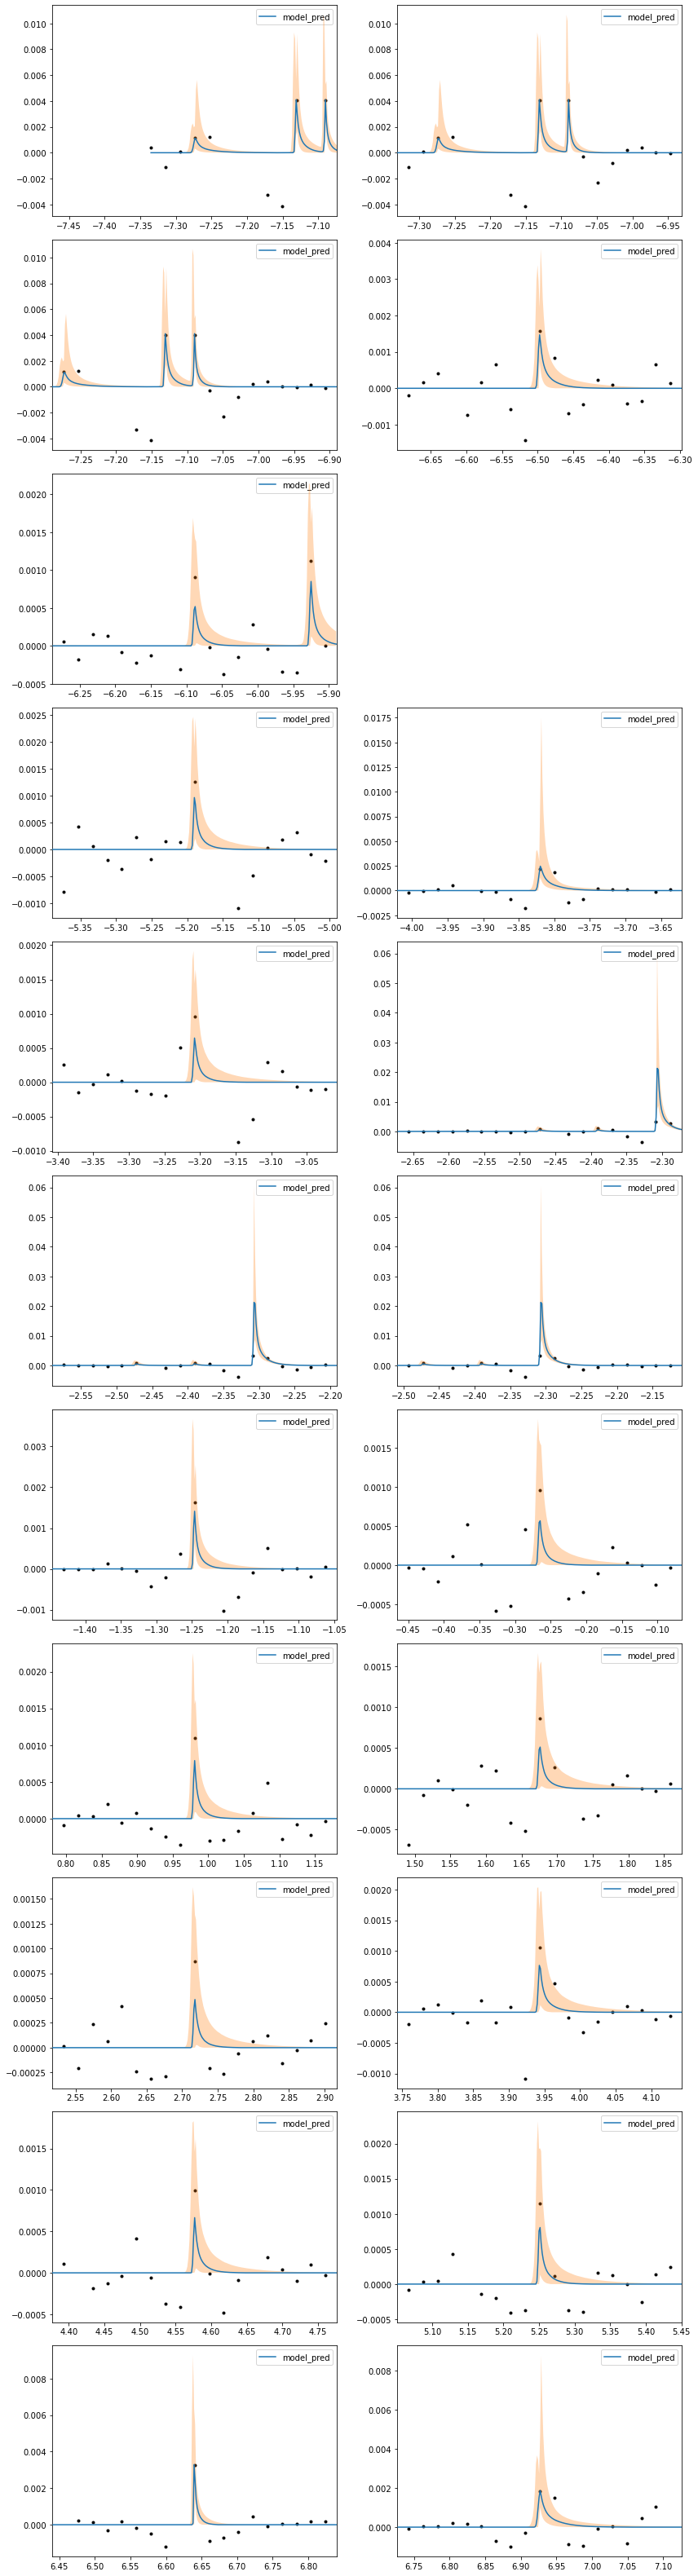

In [15]:
flc =  np.percentile(trace['flare_lc'], [5, 50, 95], axis=0)
flc_plot =  np.percentile(trace['flare_lc_pred'], [5, 50, 95], axis=0)
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks):
    timemask_t_plot = (t_plot >= tpeaks[i]-0.2) * (t_plot < tpeaks[i]+0.2)
    timemask = (x >= tpeaks[i]-0.2) * (x < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask], '.k')
    ax.plot(t_plot[timemask_t_plot], flc_plot[1][timemask_t_plot], label="model_pred", color="C1", zorder=1001)
    art = ax.fill_between(t_plot[timemask_t_plot], 
                          flc_plot[0][timemask_t_plot],
                          flc_plot[2][timemask_t_plot], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    #ax.set_ylim(np.min(y[timemask]) - 1, 1 + np.max(y[timemask]))
    ax.legend()

fig.delaxes(axes[5])
fig.tight_layout()
fig.savefig('flare-model-postflare-pregap.png')

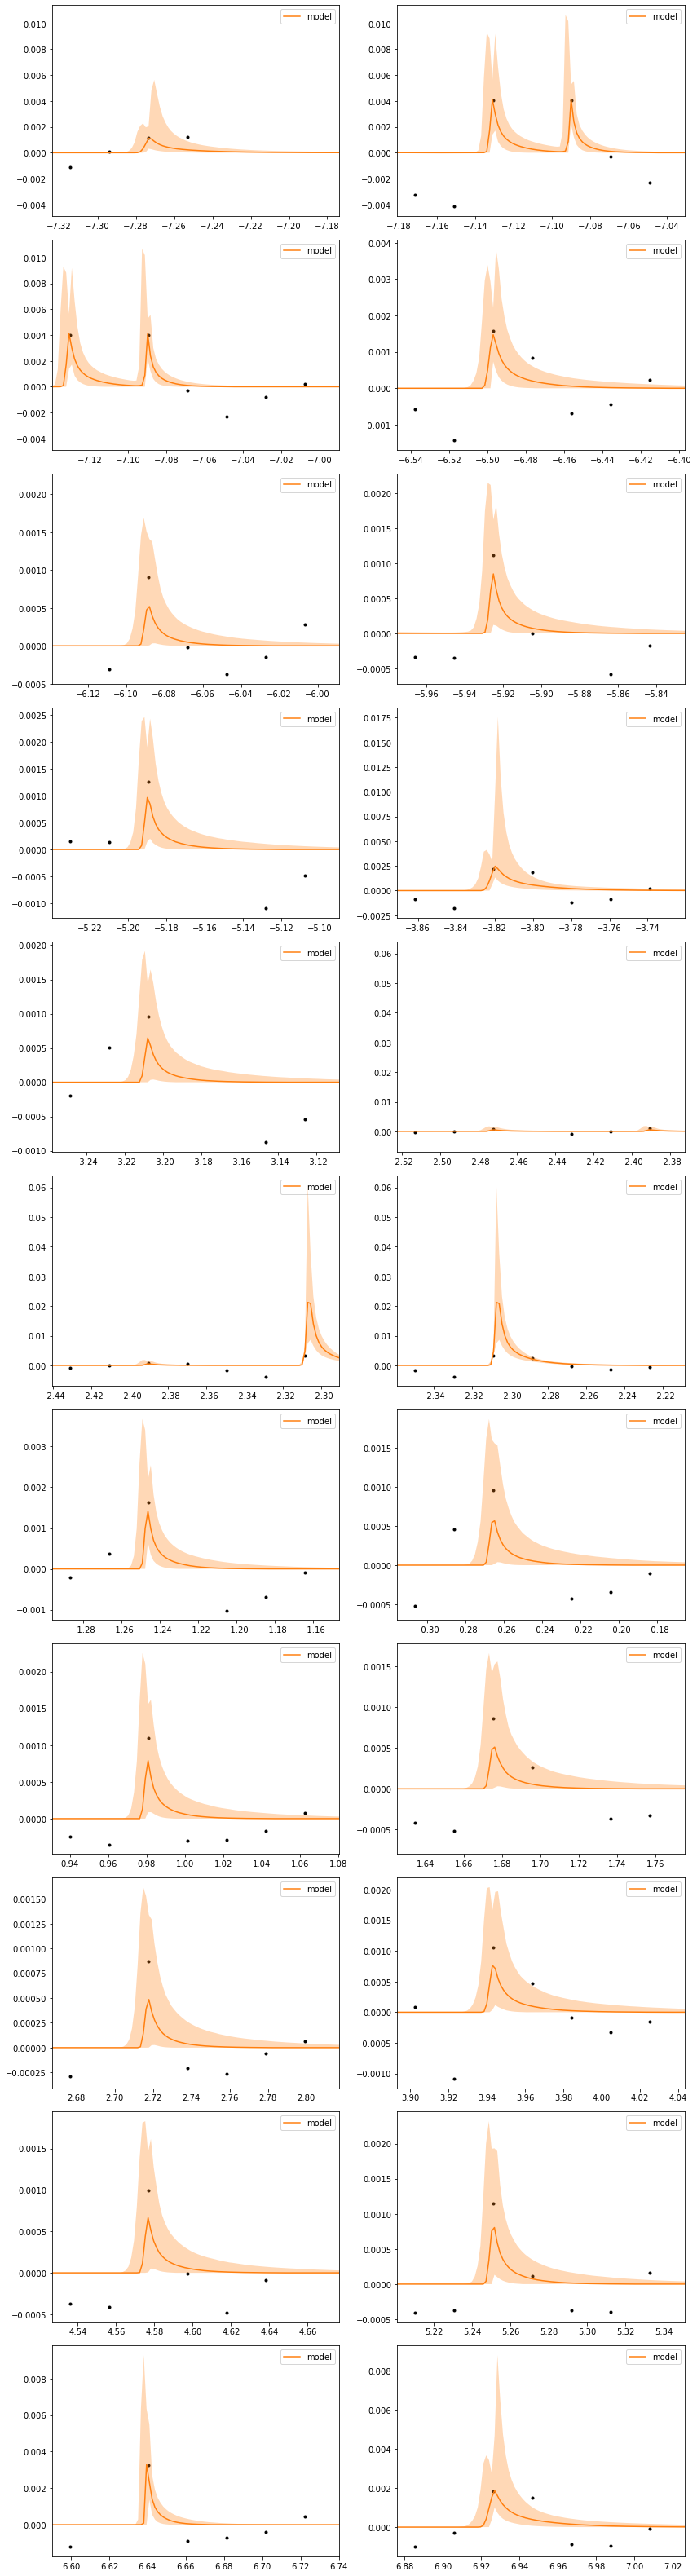

In [27]:
flc =  np.percentile(trace['flare_lc'], [5, 50, 95], axis=0)
flc_plot =  np.percentile(trace['flare_lc_pred'], [5, 50, 95], axis=0)
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks): 
    timemask = (x >= tpeaks[i]-0.2) & (x < tpeaks[i]+0.2)
    timemask_t_plot = (t_plot >= tpeaks[i]-0.2) * (t_plot < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask], '.k')
    ax.plot(t_plot[timemask_t_plot], flc_plot[1][timemask_t_plot], color="C1", label="model")
    art = ax.fill_between(t_plot[timemask_t_plot], flc_plot[0][timemask_t_plot],
                          flc_plot[2][timemask_t_plot], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.05, tpeaks[i]+0.1)
    #ax.set_ylim(np.min(y[timemask]) - 1, 1 + np.max(y[timemask]))
    ax.legend()

fig.tight_layout()
fig.savefig('flare-model-postflare-pregap.png')

In [20]:
# save out to combine with other two set of flares
#pd.Series(flc[1]).to_csv('post-flare-pre-gap-flares.csv', index=False)

In [21]:
# for some reason, pymc wants to access trace at index 0 when trace starts at 1...so I cheat to make this work
trace._straces[0] = trace._straces[1]

In [22]:
#print(samples.head())
#print(trace['tpeak'].shape[1])
#print(['tpeak__{}'.format(i), 'ampl__{}'.format(i), 'fwhm__{}'.format(i)])

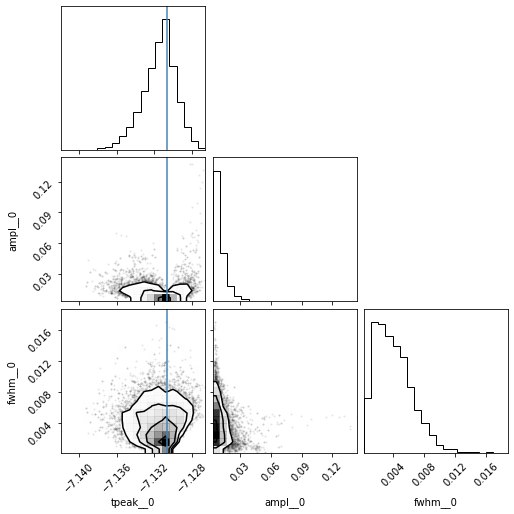

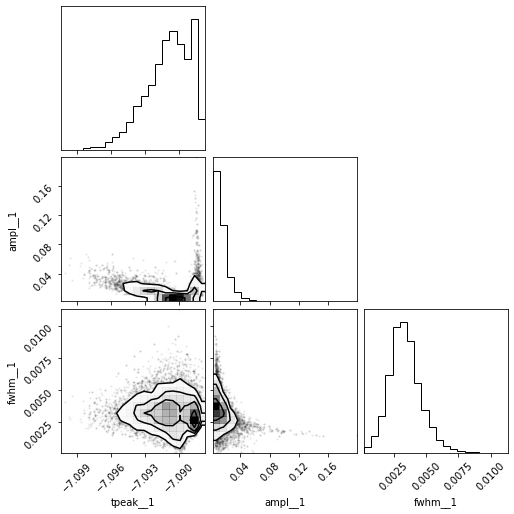

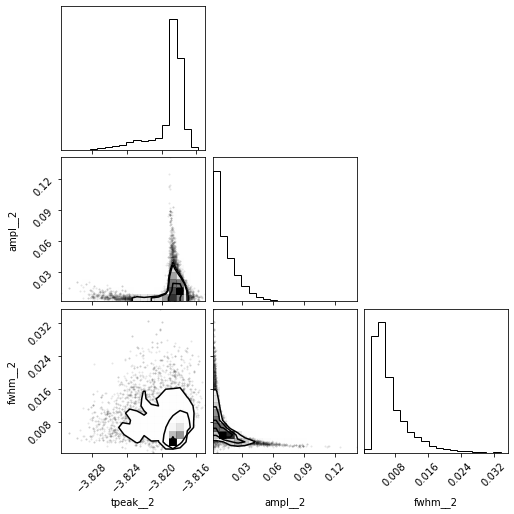

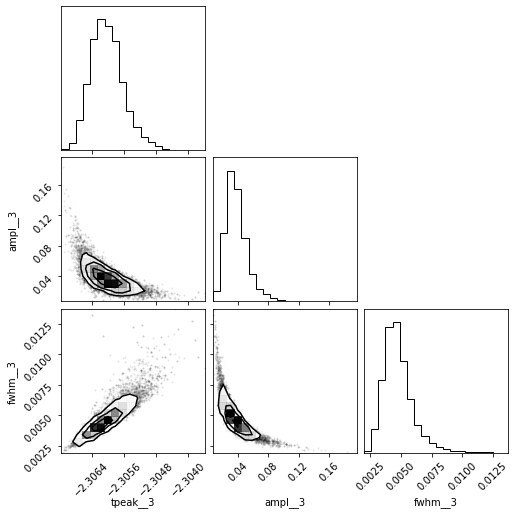

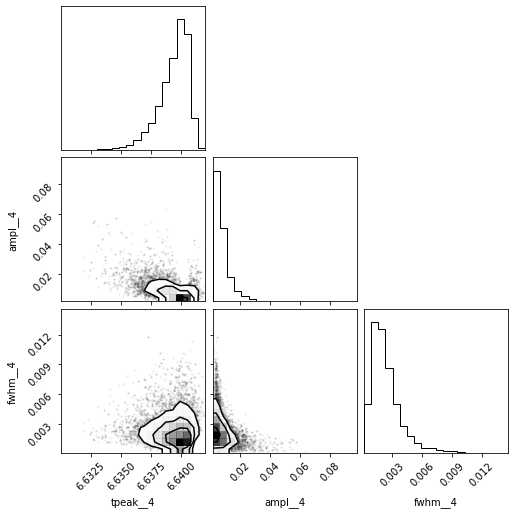

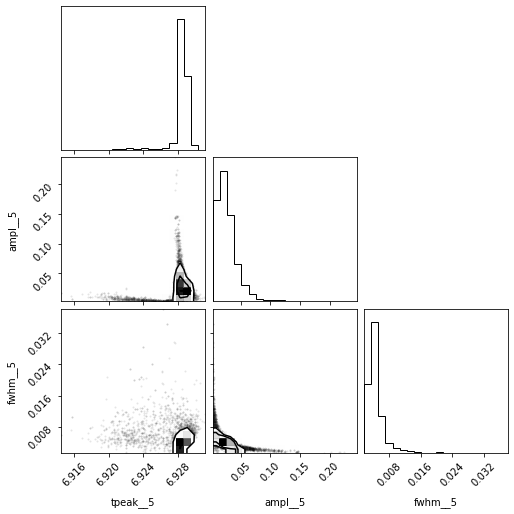

In [23]:
samples = pm.trace_to_dataframe(trace, varnames=['tpeak', 'ampl', 'fwhm'])
for i in range(trace['tpeak'].shape[1]):
    corner.corner(samples.loc[:,
                              ['tpeak__{}'.format(i), 'ampl__{}'.format(i),
                               'fwhm__{}'.format(i)]], truths=tpeaks);

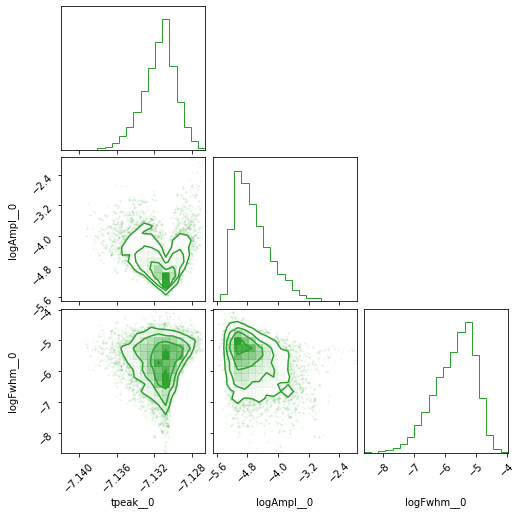

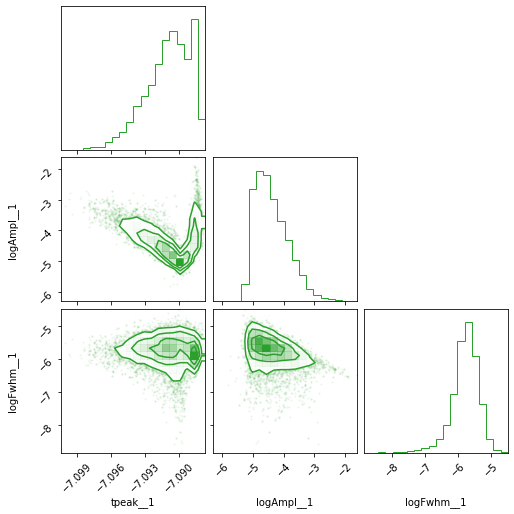

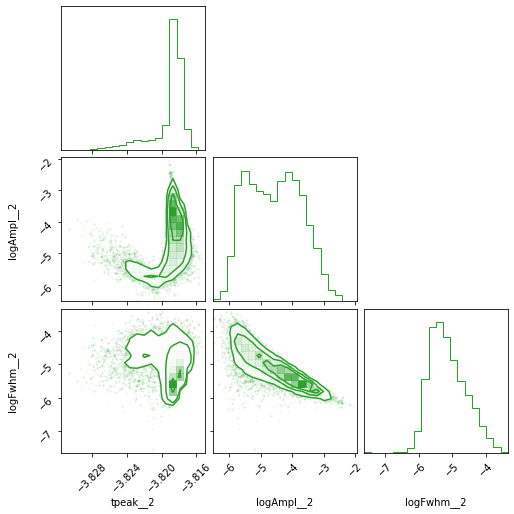

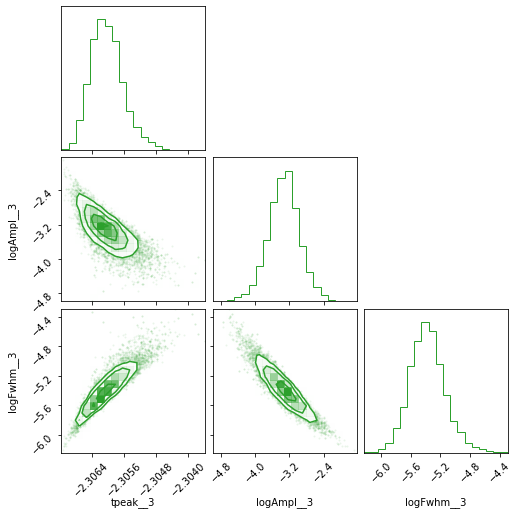

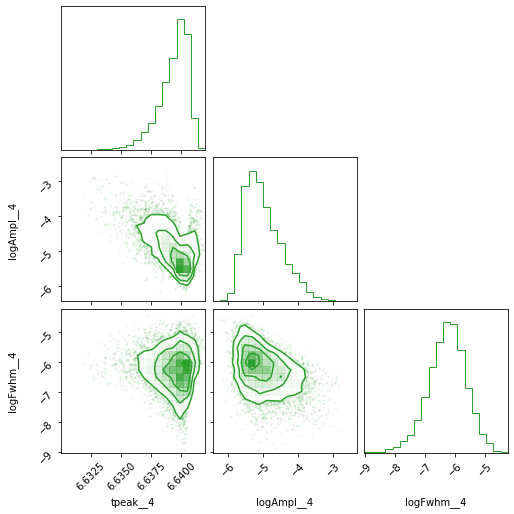

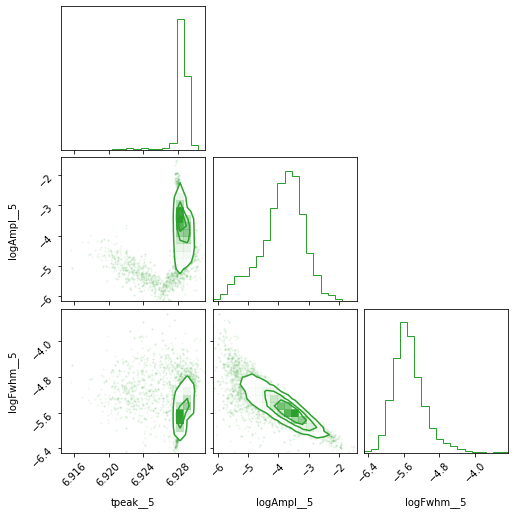

In [24]:
samples = pm.trace_to_dataframe(trace, varnames=['tpeak', 'logAmpl', 'logFwhm'])
for i in range(trace['tpeak'].shape[1]):
    corner.corner(samples.loc[:,
                              ['tpeak__{}'.format(i), 'logAmpl__{}'.format(i),
                               'logFwhm__{}'.format(i)]], color='C2');

### Flare energies

In [20]:
# get equivalent durations
ed_model = []
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) & (x < tpeaks[i]+0.2)
    ed_model.append(np.trapz(flc[1][timemask]*86400, x[timemask]))
    
print(ed_model, len(ed_model))

[20.440934658812225, 24.160258749190795, 23.233196016407785, 3.087968708473955, 2.6503307412316186, 2.7896136720960785, 3.651778963655102, 5.34351404439059, 2.336823225266646, 10.290838896845452, 13.104176855238842, 13.104176855238842, 3.7798334090324532, 1.6669997102180771, 1.5100989980896629, 1.1342427028932243, 1.4388859153655864, 1.6509327474990163, 1.2948784621024962, 1.731479430475092, 8.482343495743594, 4.278067388618879] 22


In [21]:
def calculate_energy(kp, zeropoint, ed_model):
    l_sun = 3.0128e28 * 1e7 # Watts * 1e7 erg/s per Watt
    parallax = 21.6345 # in milliarcsecs (mas)
    distance = 22.74 # 46.22
    distance = 1./(parallax*0.001) # parsecs
    print(distance)
    pre_lkp = l_sun * np.power(10, 0.4*(zeropoint-kp)) # https://iopscience.iop.org/article/10.1088/0004-637X/797/2/121/pdf
    print("log pre LKp: ", np.log10(pre_lkp)) # erg/(s*cm^2)
    lkp = (4*np.pi*distance**2) * pre_lkp * 4000
    print("log LKp: ", np.log10(lkp))
    print("ED: ", ed_model)
    try:
        return np.log10(lkp*ed_model)
    except:
        return np.log10([lkp*ed for ed in ed_model]) # show order of energy in ergs

# use kepmag value from exofop: https://exofop.ipac.caltech.edu/k2/edit_target.php?id=246301900
flare_energies = calculate_energy(kp=10.807, zeropoint=-20.24, ed_model=ed_model)
print("log flare energy: ", flare_energies)

46.22246874205551
log pre LKp:  23.060170302672592
log LKp:  31.09114643288431
ED:  [20.440934658812225, 24.160258749190795, 23.233196016407785, 3.087968708473955, 2.6503307412316186, 2.7896136720960785, 3.651778963655102, 5.34351404439059, 2.336823225266646, 10.290838896845452, 13.104176855238842, 13.104176855238842, 3.7798334090324532, 1.6669997102180771, 1.5100989980896629, 1.1342427028932243, 1.4388859153655864, 1.6509327474990163, 1.2948784621024962, 1.731479430475092, 8.482343495743594, 4.278067388618879]
log flare energy:  [32.40164718 32.47424801 32.45725539 31.58081932 31.51444651 31.5366905
 31.65365092 31.81897339 31.45977229 32.10359721 32.20855618 32.20855618
 31.66861909 31.31308196 31.27015185 31.14585243 31.24917279 31.30887582
 31.20337544 31.32956377 32.01966229 31.72239405]


In [22]:
# get unnormalized times
tpeaks_unnormalized = [tpeak+calculate_ref_time(post) for tpeak in tpeaks]
fe_dict = {'time': tpeaks_unnormalized, 'flare_energies': flare_energies, 'ed': ed_model}
fe = pd.DataFrame(fe_dict)
print(fe)
#fe.to_csv('flare_energies_post.csv')

           time  flare_energies         ed
0   2938.497351       32.401647  20.440935
1   2938.640373       32.474248  24.160259
2   2938.681236       32.457255  23.233196
3   2939.273753       31.580819   3.087969
4   2939.682385       31.514447   2.650331
5   2939.845838       31.536690   2.789614
6   2940.581375       31.653651   3.651779
7   2941.950291       31.818973   5.343514
8   2942.563239       31.459772   2.336823
9   2943.298775       32.103597  10.290839
10  2943.380501       32.208556  13.104177
11  2943.462228       32.208556  13.104177
12  2944.524669       31.668619   3.779833
13  2945.505384       31.313082   1.667000
14  2946.751708       31.270152   1.510099
15  2947.446380       31.145852   1.134243
16  2948.488389       31.249173   1.438886
17  2949.714280       31.308876   1.650933
18  2950.347658       31.203375   1.294878
19  2951.021898       31.329564   1.731479
20  2952.411241       32.019662   8.482343
21  2952.697283       31.722394   4.278067


In [42]:
"""
# tryna get tpeaks back in units of MJD
def find_flares(lc):

    # find some flares
    mflare = resid < 3.5 * np.sqrt(np.mean(resid**2))
    lc.CADENCENO = lc.CADENCENO
    cads = lc.CADENCENO - list(lc.CADENCENO)[0] # index at 0
    ref_time = calculate_ref_time(lc)
    x = lc.TIME
    y = resid # data with savgol subtracted

    fidx = cads.loc[~mflare][:-1]#[np.diff(cads[~mflare]) < 1]
    fidx = list(fidx) # address indexing errors
    print(fidx)
    npts = np.array([])
    i = 0
    n = 1
    while True:
        try:
            if fidx[i + 1] == fidx[i] + n:
                # measure flare: keep track of number of points (fatness) of a flare
                fidx = np.delete(fidx, i + 1)
                n += 1
            elif fidx[i+1] - fidx[i] < 3:
                # specifically to deal with a flare that gets double counted because it has a dimple or something
                fidx = np.delete(fidx, i+1)
                n = 1
            else:
                # count flare: concatenate to array, advance, and reset count
                npts = np.r_[npts, n+1] 
                i += 1
                n = 1
        except IndexError:
            npts = np.r_[npts, n+1]
            break
    tpeaks = np.array([x.loc[(lc.CADENCENO - list(lc.CADENCENO)[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
    ampls = np.array([resid.loc[(lc.CADENCENO - list(lc.CADENCENO)[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
    fwhms = np.asarray(npts) * (2/1440)
    npeaks = np.shape(tpeaks)[0]
    #print(tpeaks, ampls, fwhms, npeaks)
    print(tpeaks)
    return x, y, tpeaks, ampls, fwhms, npeaks

x, y, tpeaks, ampls, fwhms, npeaks = find_flares(post)
"""

[10, 12, 172, 173, 246, 247, 684, 698]
[2938.64037271 2941.95029121 2943.46222768 2952.41124125 2952.69728255]


/Users/chris/anaconda2/lib/python3.6/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


### Subtract flare light curve

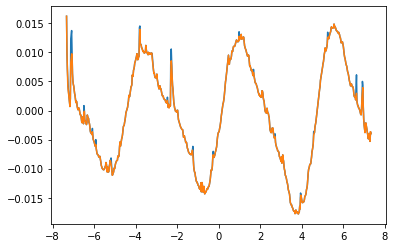

In [37]:
gp_mean = norm_y-flc[1] # mean for GP for total light curve fit is observed light curve - flare light curve
plt.plot(x, norm_y)
plt.plot(x, norm_y-flc[1])
#plt.plot(x, flc[1])
plt.show()

{'index': 72, 'log_power': -10.315331709113536, 'period': 4.514986633900994, 'period_uncert': 0.5140792479379249}


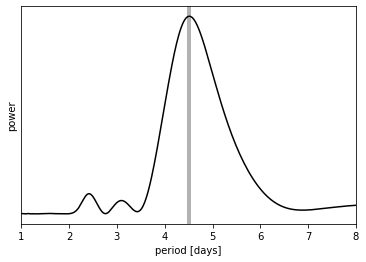

In [38]:
# periodogram
results = xo.estimators.lomb_scargle_estimator(
    x, gp_mean, max_peaks=1, min_period=1.0, max_period=8.0, samples_per_peak=50 # replaced y with gp_mean
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
_ = plt.ylabel("power")
print(peak)

### Model flare-subtracted light curve with pyMC3 and GP likelihood

In [39]:
# get a smoothed version of the light curve
norm_y = normalize_flux(post.PDCSAP_FLUX)
norm_yerr = normalize_flux(post.PDCSAP_FLUX_ERR)
print(norm_y)
print(norm_yerr) # how to deal with errors in normalized time series? 

1618    0.016230
1619    0.009903
1620    0.007120
1621    0.005267
1622    0.003738
          ...   
2332   -0.003996
2333   -0.004977
2334   -0.005304
2335   -0.003642
2336   -0.003975
Name: PDCSAP_FLUX, Length: 671, dtype: float32
1618    0.004439
1619    0.002230
1620    0.001293
1621    0.000778
1622    0.000317
          ...   
2332    0.006678
2333    0.005123
2334    0.004690
2335    0.004112
2336    0.005324
Name: PDCSAP_FLUX_ERR, Length: 671, dtype: float32


In [40]:
# okay, I got the period to work out. How about I don't fit every little spike now with my GP? 
# It works!! Hell yeah.
with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=np.mean(gp_mean), sd=np.std(gp_mean)) # replaced 0.0 and 10.0
    # A jitter term describing excess white noise
    jitter = pm.Lognormal("jitter", mu=np.log(np.mean(norm_yerr)), sd=np.log(np.std(norm_yerr))) # try not logging
    #jitter = pm.Lognormal("jitter", mu=0., sd=np.std(norm_yerr))
    
    # A term to describe the non-periodic variability
    #sigma = pm.InverseGamma(
    #    "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0))
    #rho = pm.InverseGamma(
    #    "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0))
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 2.5))
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 1.5))
    
    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 2.0)) # formerly Beta param was 5.0, not 2.0
    
    #period = pm.Lognormal("period", mu=np.log(peak["period"]), sd=1.0) 
    period = pm.Normal("period", mu=peak["period"], sd=1.0)  

    #Q0 = pm.Lognormal("Q0", mu=0, sd=2) # or np.log(np.mean(gp_mean))?  
    #dQ = pm.Lognormal("dQ", mu=0, sd=2) # or np.log(np.mean(gp_mean))?
    Q0 = pm.Lognormal("Q0", mu=0, sd=2) # or np.log(np.mean(gp_mean))?  
    dQ = pm.Lognormal("dQ", mu=0, sd=2) # or np.log(np.mean(gp_mean))?
    f = pm.Uniform("f", lower=0.1, upper=1.0)
    
    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0) # tweaking rho and sigma affects whether I'm touch-tight
    kernel += terms.RotationTerm(
        sigma=sigma_rot, period=period, Q0=Q0, dQ=dQ, f=f)
    gp = GaussianProcess(
        kernel, t=x, mean=mean, 
        diag=np.asarray(norm_yerr**2)+jitter**2, quiet=True) # diag = norm_yerr**2 + jitter**2

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=norm_y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(norm_y))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()

optimizing logp for variables: [f, dQ, Q0, period, sigma_rot, rho, sigma, jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 598.1358042697661 -> 3030.6957608576413


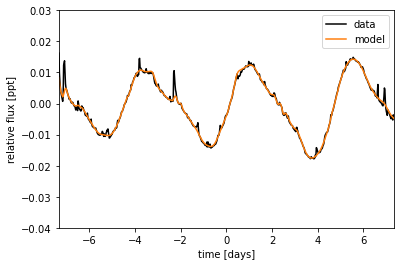

In [43]:
# plot maximum a posteriori model prediction

plt.plot(x, norm_y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.ylim(-0.04, 0.03)
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
#_ = plt.title("pyMC model of EPIC 246301900 light curve")
plt.savefig('quiescent_gp_post.png')
plt.show()

In [36]:
# sample from posterior
np.random.seed(10863087)
with model:
    trace = pmx.sample(
        tune=2500,
        draws=2500,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.95,
    )

Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f, dQ, Q0, period, sigma_rot, rho, sigma, jitter, mean]
INFO:pymc3:NUTS: [f, dQ, Q0, period, sigma_rot, rho, sigma, jitter, mean]


Sampling 2 chains for 2_500 tune and 2_500 draw iterations (5_000 + 5_000 draws total) took 525 seconds.
INFO:pymc3:Sampling 2 chains for 2_500 tune and 2_500 draw iterations (5_000 + 5_000 draws total) took 525 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [37]:
with model:
    summary = pm.summary(
        trace,
        var_names=[
            "f",
            "dQ",
            "Q0",
            "period",
            "sigma_rot",
            "rho",
            "sigma",
            "jitter",
            "mean",
        ],
    )
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
f,0.271,0.204,0.100,0.718,0.003,0.002,4009.0,3393.0,5807.0,3004.0,1.0
dQ,7.257,31.695,0.001,21.969,0.533,0.377,3538.0,3538.0,6355.0,3635.0,1.0
Q0,15279.374,19123.104,878.935,43482.245,342.310,259.679,3121.0,2712.0,4916.0,3288.0,1.0
period,6.968,0.884,5.333,8.643,0.011,0.008,6605.0,6398.0,6622.0,3210.0,1.0
sigma_rot,1.182,0.164,0.909,1.516,0.002,0.002,5464.0,4992.0,5941.0,3376.0,1.0
rho,76.454,11.088,58.296,97.982,0.148,0.110,5584.0,5074.0,6170.0,3285.0,1.0
sigma,0.999,0.164,0.696,1.294,0.002,0.002,6743.0,5969.0,7200.0,3713.0,1.0
jitter,0.000,0.000,0.000,0.000,0.000,0.000,4974.0,4803.0,2552.0,2427.0,1.0
mean,-0.000,0.009,-0.016,0.016,0.000,0.000,6184.0,1791.0,6227.0,3348.0,1.0


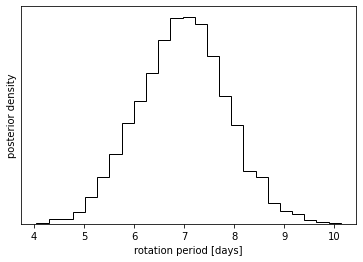

In [38]:
period_samples = trace["period"]
plt.hist(period_samples, 25, histtype="step", color="k", density=True)
plt.yticks([])
plt.xlabel("rotation period [days]")
_ = plt.ylabel("posterior density")
plt.savefig("period_posterior_post.png")

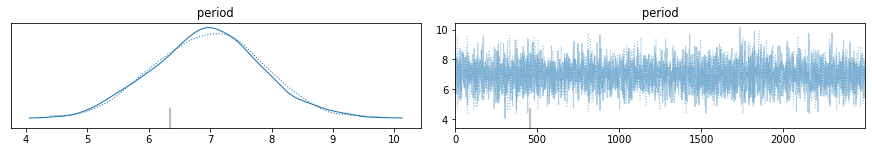

In [39]:
# show burn-in
import arviz as az

with model:
    az.plot_trace(trace, var_names=["period"])
plt.savefig("period_trace_post.png")